In [313]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
sys.path.insert(0, os.path.abspath('../'))
from src.lib import utils
from src.lib import cell_blobs as blobsutils

In [2]:
imgs_dir = '../data/raw/images'
img_name = 'ACTB_B2_NO'
nuclei_img, ccj_img, seg_img, sk_img = utils.load_images(imgs_dir, img_name)

([], <a list of 0 Text major ticklabel objects>)

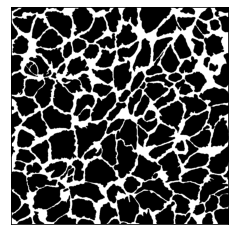

In [3]:
plt.imshow(seg_img, cmap='gray')
plt.xticks([])
plt.yticks([])

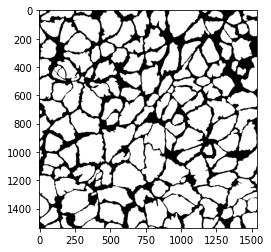

In [4]:
seg_inv = cv2.bitwise_not(seg_img)
plt.imshow(seg_inv, cmap='gray')


In [380]:
contours, moments = blobsutils.get_contours_and_moments(seg_img)

In [381]:
len(contours), len(moments)

(154, 154)

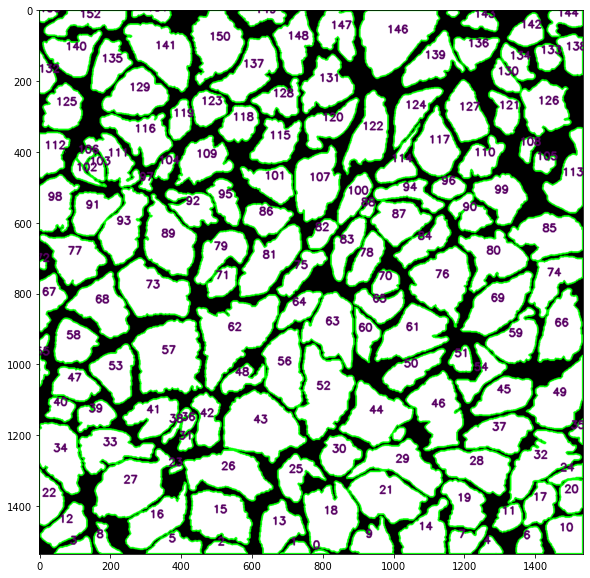

In [382]:
contours_img = cv2.cvtColor(seg_inv, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img, contours, -1, (0, 255, 0), 3)
for index, moment in enumerate(moments):
    cx = int(moment['m10']/moment['m00'])
    cy = int(moment['m01']/moment['m00'])
    contours_img = cv2.putText(contours_img, f'{index}', (cx - 20, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (88, 0, 99), 3)

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(contours_img)

In [10]:
contours_imgs = [blobsutils.contour_to_image(cnt) for cnt in contours]

In [11]:
fds = [blobsutils.fractal_dimension(img) for img in contours_imgs]

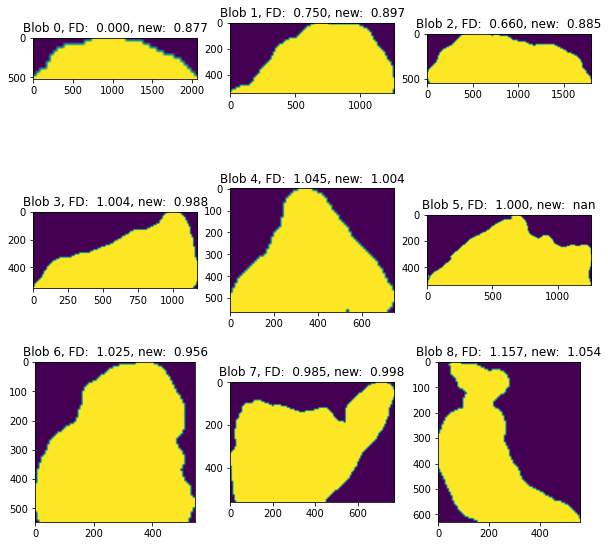

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, (ax, cimg, fd) in enumerate(zip(axes.flatten(), contours_imgs[:9], fds[:9])):
    cimg_resized = blobsutils.resize_up_to(cimg, 512)
    ax.imshow(cimg_resized)
    new_fd = blobsutils.fractal_dimension(cimg_resized)
    ax.set_title(f'Blob {idx}, FD: {fd: .3f}, new: {new_fd: .3f}')

In [206]:
def count_boxes_naive(xs, ys, k, k_max):
    range_y_max = ys.max() - ys.min()
    indexes_x = np.arange(0, len(xs) + 1, 2**k)
    ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()
    S = 0
    n = 0
    for i in range(len(indexes_x) - 1):
        x_min, x_max = indexes_x[i], indexes_x[i+1]
        for j in range(len(ranges_y) - 1):
            n += 1
            y_min, y_max = ranges_y[j], ranges_y[j+1]
            current_slice = ys[x_min:x_max]
            S += ((current_slice >= y_min) & (current_slice <= y_max)).any()
    return S

In [210]:
def count_boxes(xs, ys, k, k_max):
    range_y_max = ys.max() - ys.min()
    indexes_x = np.arange(0, len(xs), 2**k)
    ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()
    S = []
    for j in range(len(ranges_y) - 1):
        r = (ys >= ranges_y[j]) & (ys <= ranges_y[j+1])
        S.append(np.add.reduceat(r, indexes_x))
    boxes = np.vstack(S)
    # print(boxes) # With this you can see the formation of the plot!
    return len(np.where(boxes > 0)[0])

In [227]:
def fractal_dimension_1d(xs, ys, n_points=8192):
    def count_boxes_1d(xs, ys, k, k_max):
        range_y_max = ys.max() - ys.min()
        indexes_x = np.arange(0, len(xs), 2**k)
        ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()
        S = []
        # Optimization: we compute the if all the ys are in some y-range at the same time, and then we collapse the result into boxes
        # (yeah, I feel proud about this trick)
        for j in range(len(ranges_y) - 1):
            r = (ys >= ranges_y[j]) & (ys <= ranges_y[j+1])
            S.append(np.add.reduceat(r, indexes_x))
        boxes = np.vstack(S)
        # print(boxes) # With this you can see the formation of the plot!
        return len(np.where(boxes > 0)[0])
    
    f_interp = interp1d(xs, ys)
    xs_new = np.linspace(0, len(xs) - 1, n_points, endpoint=True)
    ys_new = f_interp(xs_new)

    k_max = int(np.floor(np.log2(n_points)))
    ks = np.arange(k_max, 1, -1)
    sizes = 2**ks

    counts = []
    for k in ks:
        counts.append(count_boxes(xs_new, ys_new, k, k_max))
    
    coeffs = np.polyfit(np.log(1/sizes), np.log(counts), 1)
    return coeffs[0]

In [242]:
def get_radial_dimension(cnt, moment=None, normalize=True):
    if moment is None:
        moment = cv2.moments(cnt)
    cx = int(moment['m10']/moment['m00'])
    cy = int(moment['m01']/moment['m00'])

    cnt_reshaped = cnt.reshape(len(cnt), 2)
    rd = np.linalg.norm(cnt_reshaped - [cx, cy], axis=1)
    if normalize:
        rd /= rd.max()
    return rd

In [317]:
cnt = contours[0]
mnt = moments[0]
cx = int(moment['m10']/moment['m00'])
cy = int(moment['m01']/moment['m00'])
cnt_reshaped = cnt.reshape(len(cnt), 2)

In [318]:
cnt_reshaped

array([[ 788, 1524],
       [ 787, 1525],
       [ 786, 1525],
       [ 785, 1526],
       [ 784, 1526],
       [ 783, 1526],
       [ 782, 1526],
       [ 781, 1526],
       [ 780, 1526],
       [ 779, 1527],
       [ 778, 1527],
       [ 777, 1528],
       [ 776, 1529],
       [ 776, 1530],
       [ 775, 1531],
       [ 775, 1532],
       [ 774, 1533],
       [ 773, 1533],
       [ 772, 1534],
       [ 771, 1535],
       [ 772, 1535],
       [ 773, 1535],
       [ 774, 1535],
       [ 775, 1535],
       [ 776, 1535],
       [ 777, 1535],
       [ 778, 1535],
       [ 779, 1535],
       [ 780, 1535],
       [ 781, 1535],
       [ 782, 1535],
       [ 783, 1535],
       [ 784, 1535],
       [ 785, 1535],
       [ 786, 1535],
       [ 787, 1535],
       [ 788, 1535],
       [ 789, 1535],
       [ 790, 1535],
       [ 791, 1535],
       [ 792, 1535],
       [ 793, 1535],
       [ 794, 1535],
       [ 795, 1535],
       [ 796, 1535],
       [ 797, 1535],
       [ 798, 1535],
       [ 799,

In [243]:
rds = []
for cnt, mnt in zip(contours, moments):
    rds.append(get_radial_dimension(cnt, mnt))

In [244]:
fds = []
for index, rd in enumerate(rds):
    print(index)
    xs = np.arange(0, len(rd))
    fd = fractal_dimension_1d(xs, rd, n_points=2**12)
    fds.append(fd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


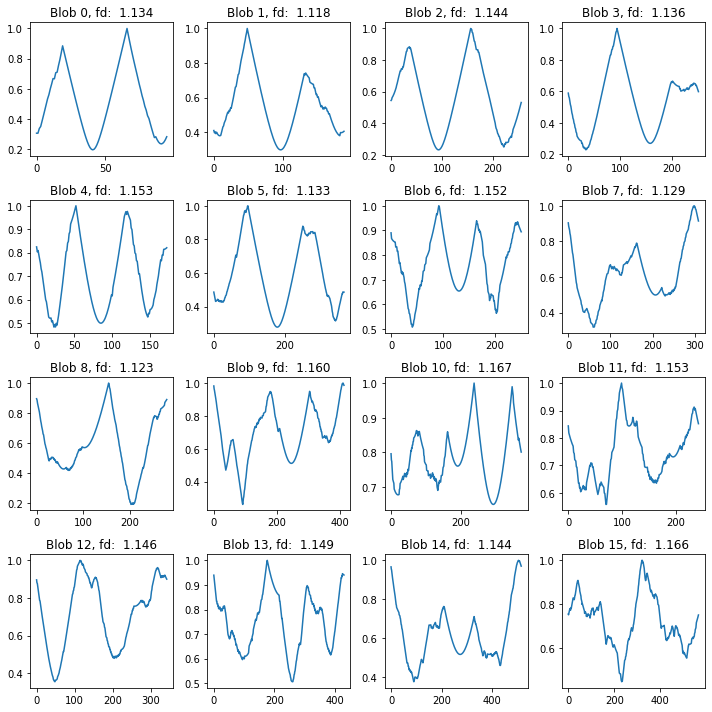

In [245]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for index, (ax, rd, fd) in enumerate(zip(axes.flatten(), rds, fds)):
    ax.plot(rd)
    ax.set_title(f'Blob {index}, fd: {fd: .3f}')
plt.tight_layout()

In [252]:
fds = np.array(fds)
rds = np.array(rds)
sort_index = fds.argsort()

fds = fds[sort_index]
rds = rds[sort_index]

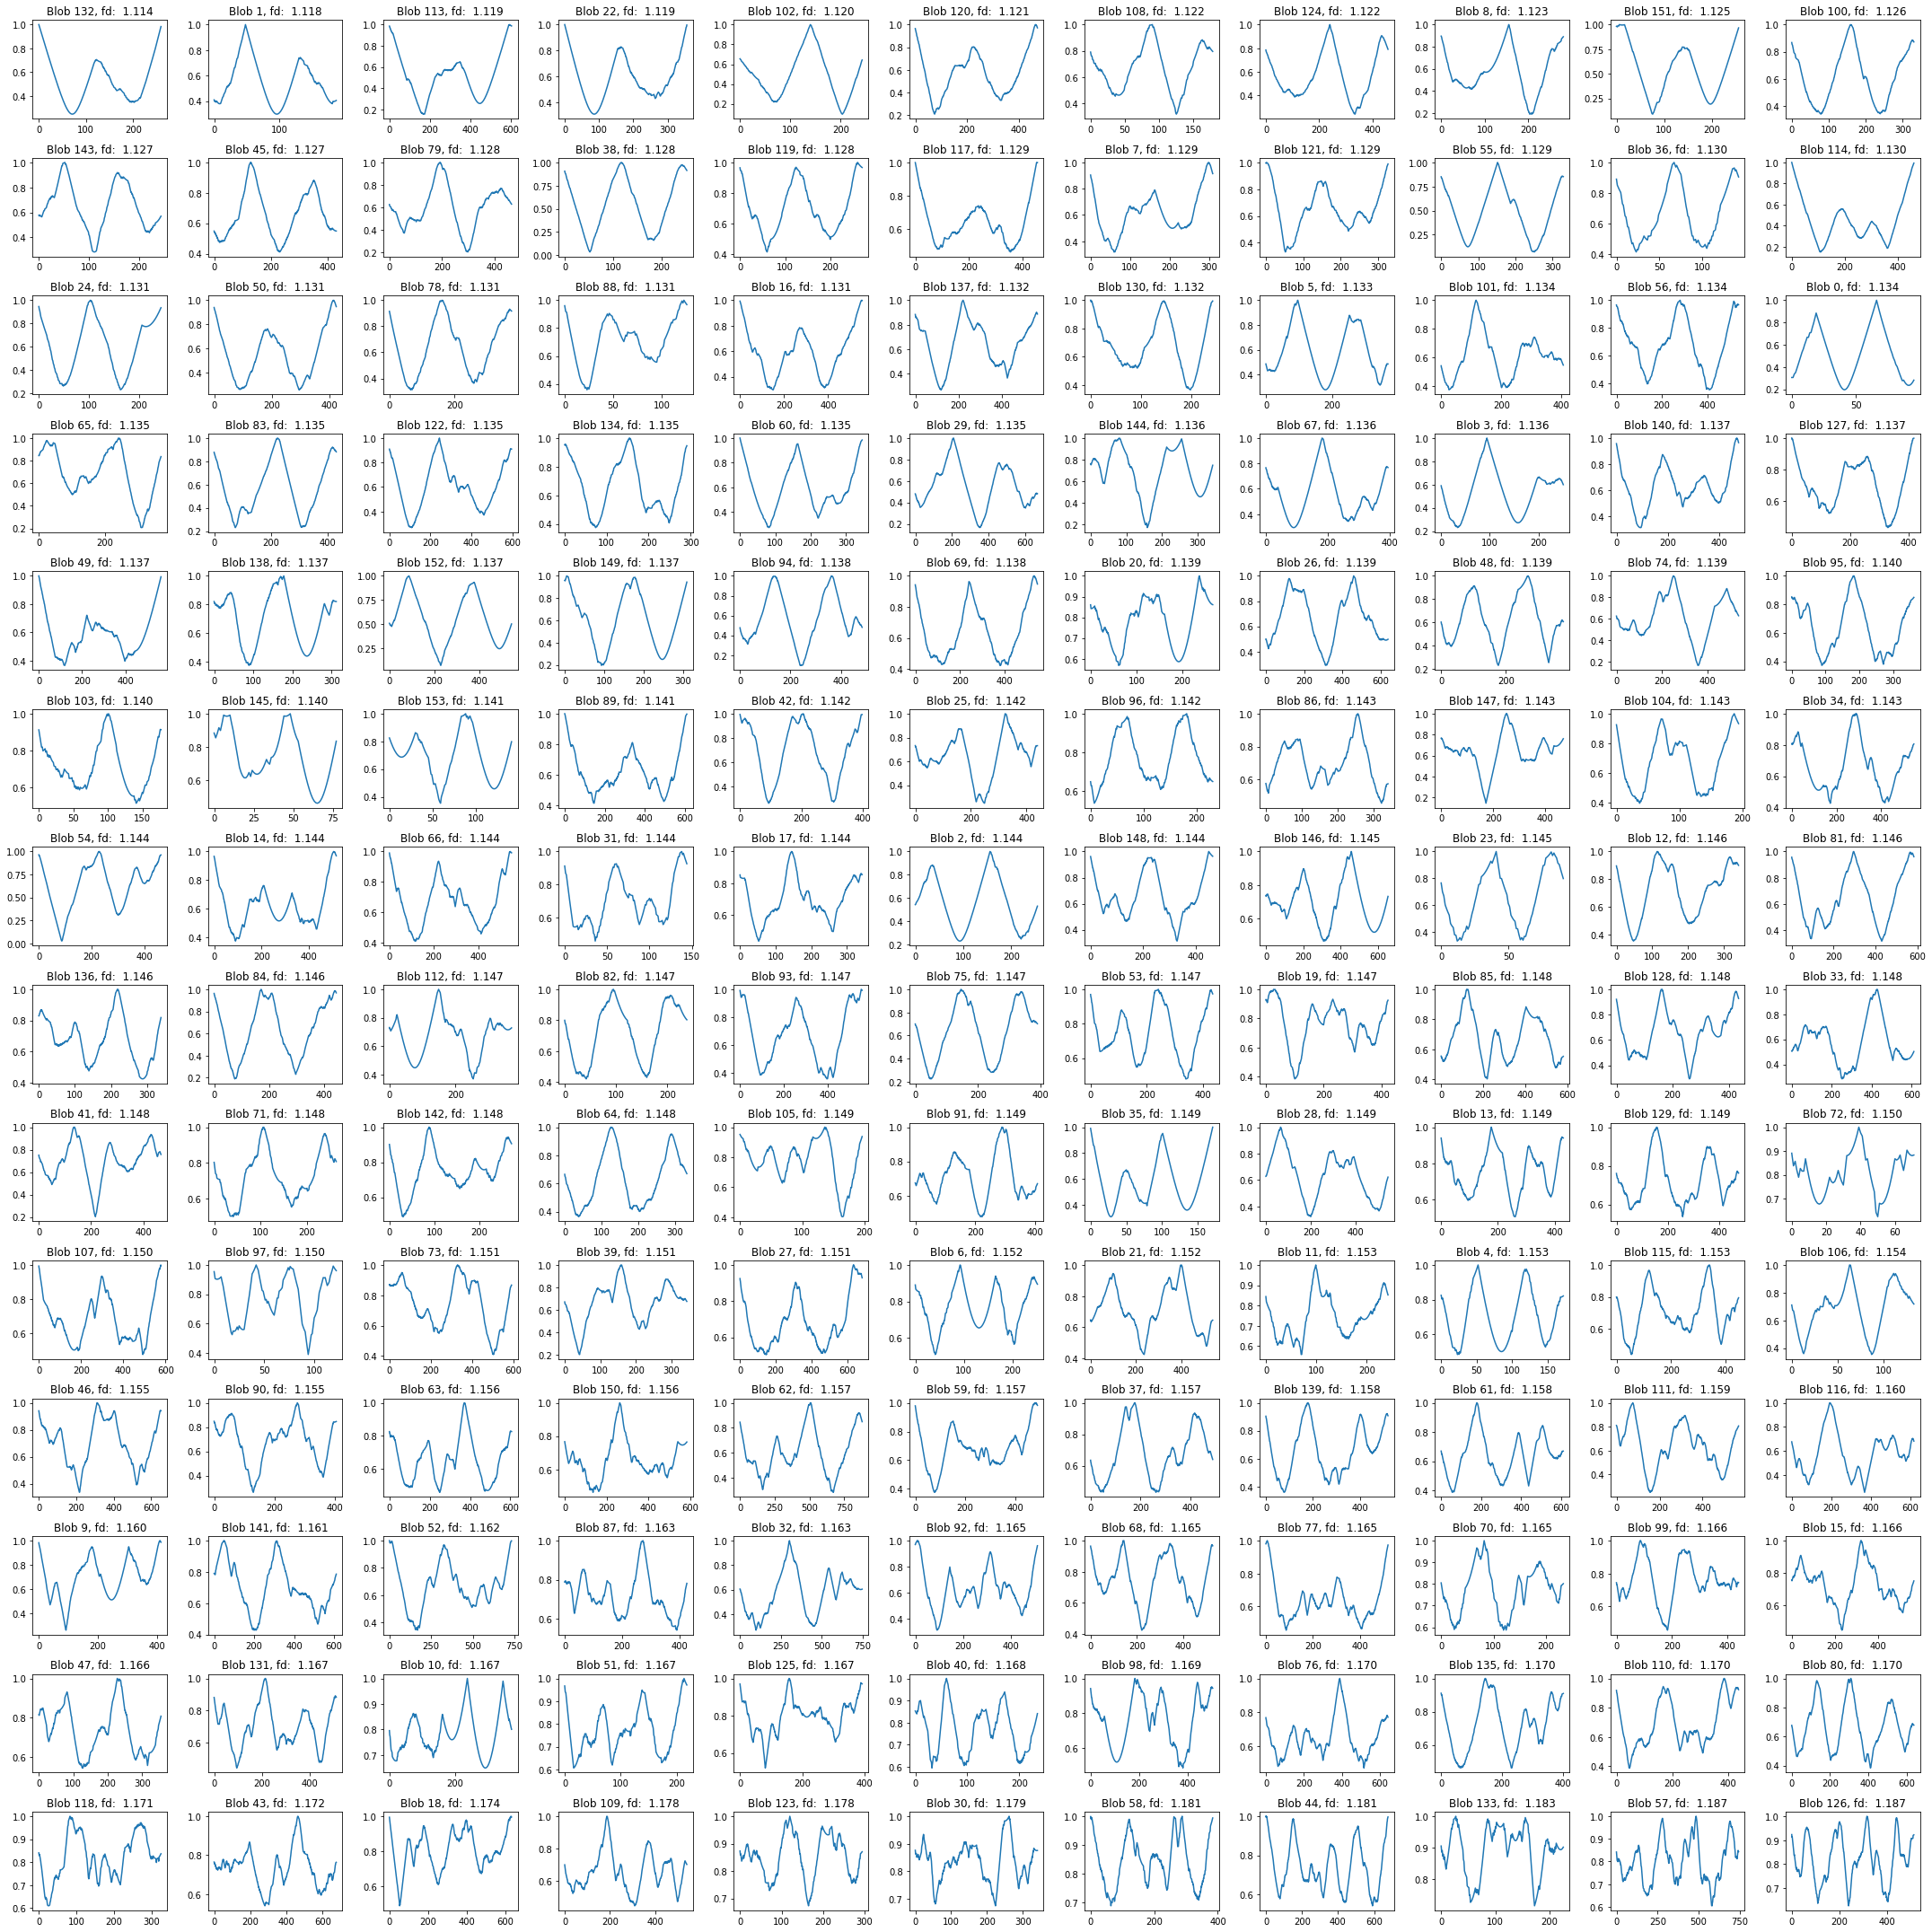

In [254]:
fig, axes = plt.subplots(14, 11, figsize=(30, 30))

for ax, rd, fd, idx in zip(axes.flatten(), rds, fds, sort_index):
    ax.plot(rd)
    ax.set_title(f'Blob {idx}, fd: {fd: .3f}')
plt.tight_layout()

In [274]:
cimgs = [blobsutils.contour_to_image(cnt) for cnt in contours]

In [299]:
cimgs_centroids = []
for idx, cimg in enumerate(cimgs):
    moment = moments[idx]
    cnt = contours[idx]
    bbox = cv2.boundingRect(cnt)
    cimg_centroid = cv2.cvtColor(cimg, cv2.COLOR_GRAY2BGR)
    cx = int(moment['m10']/moment['m00']) - bbox[0]
    cy = int(moment['m01']/moment['m00']) - bbox[1]
    cimg_centroid = cv2.circle(cimg_centroid, (cx, cy), 3, (255, 0, 0), -1)
    cimgs_centroids.append(cimg_centroid)

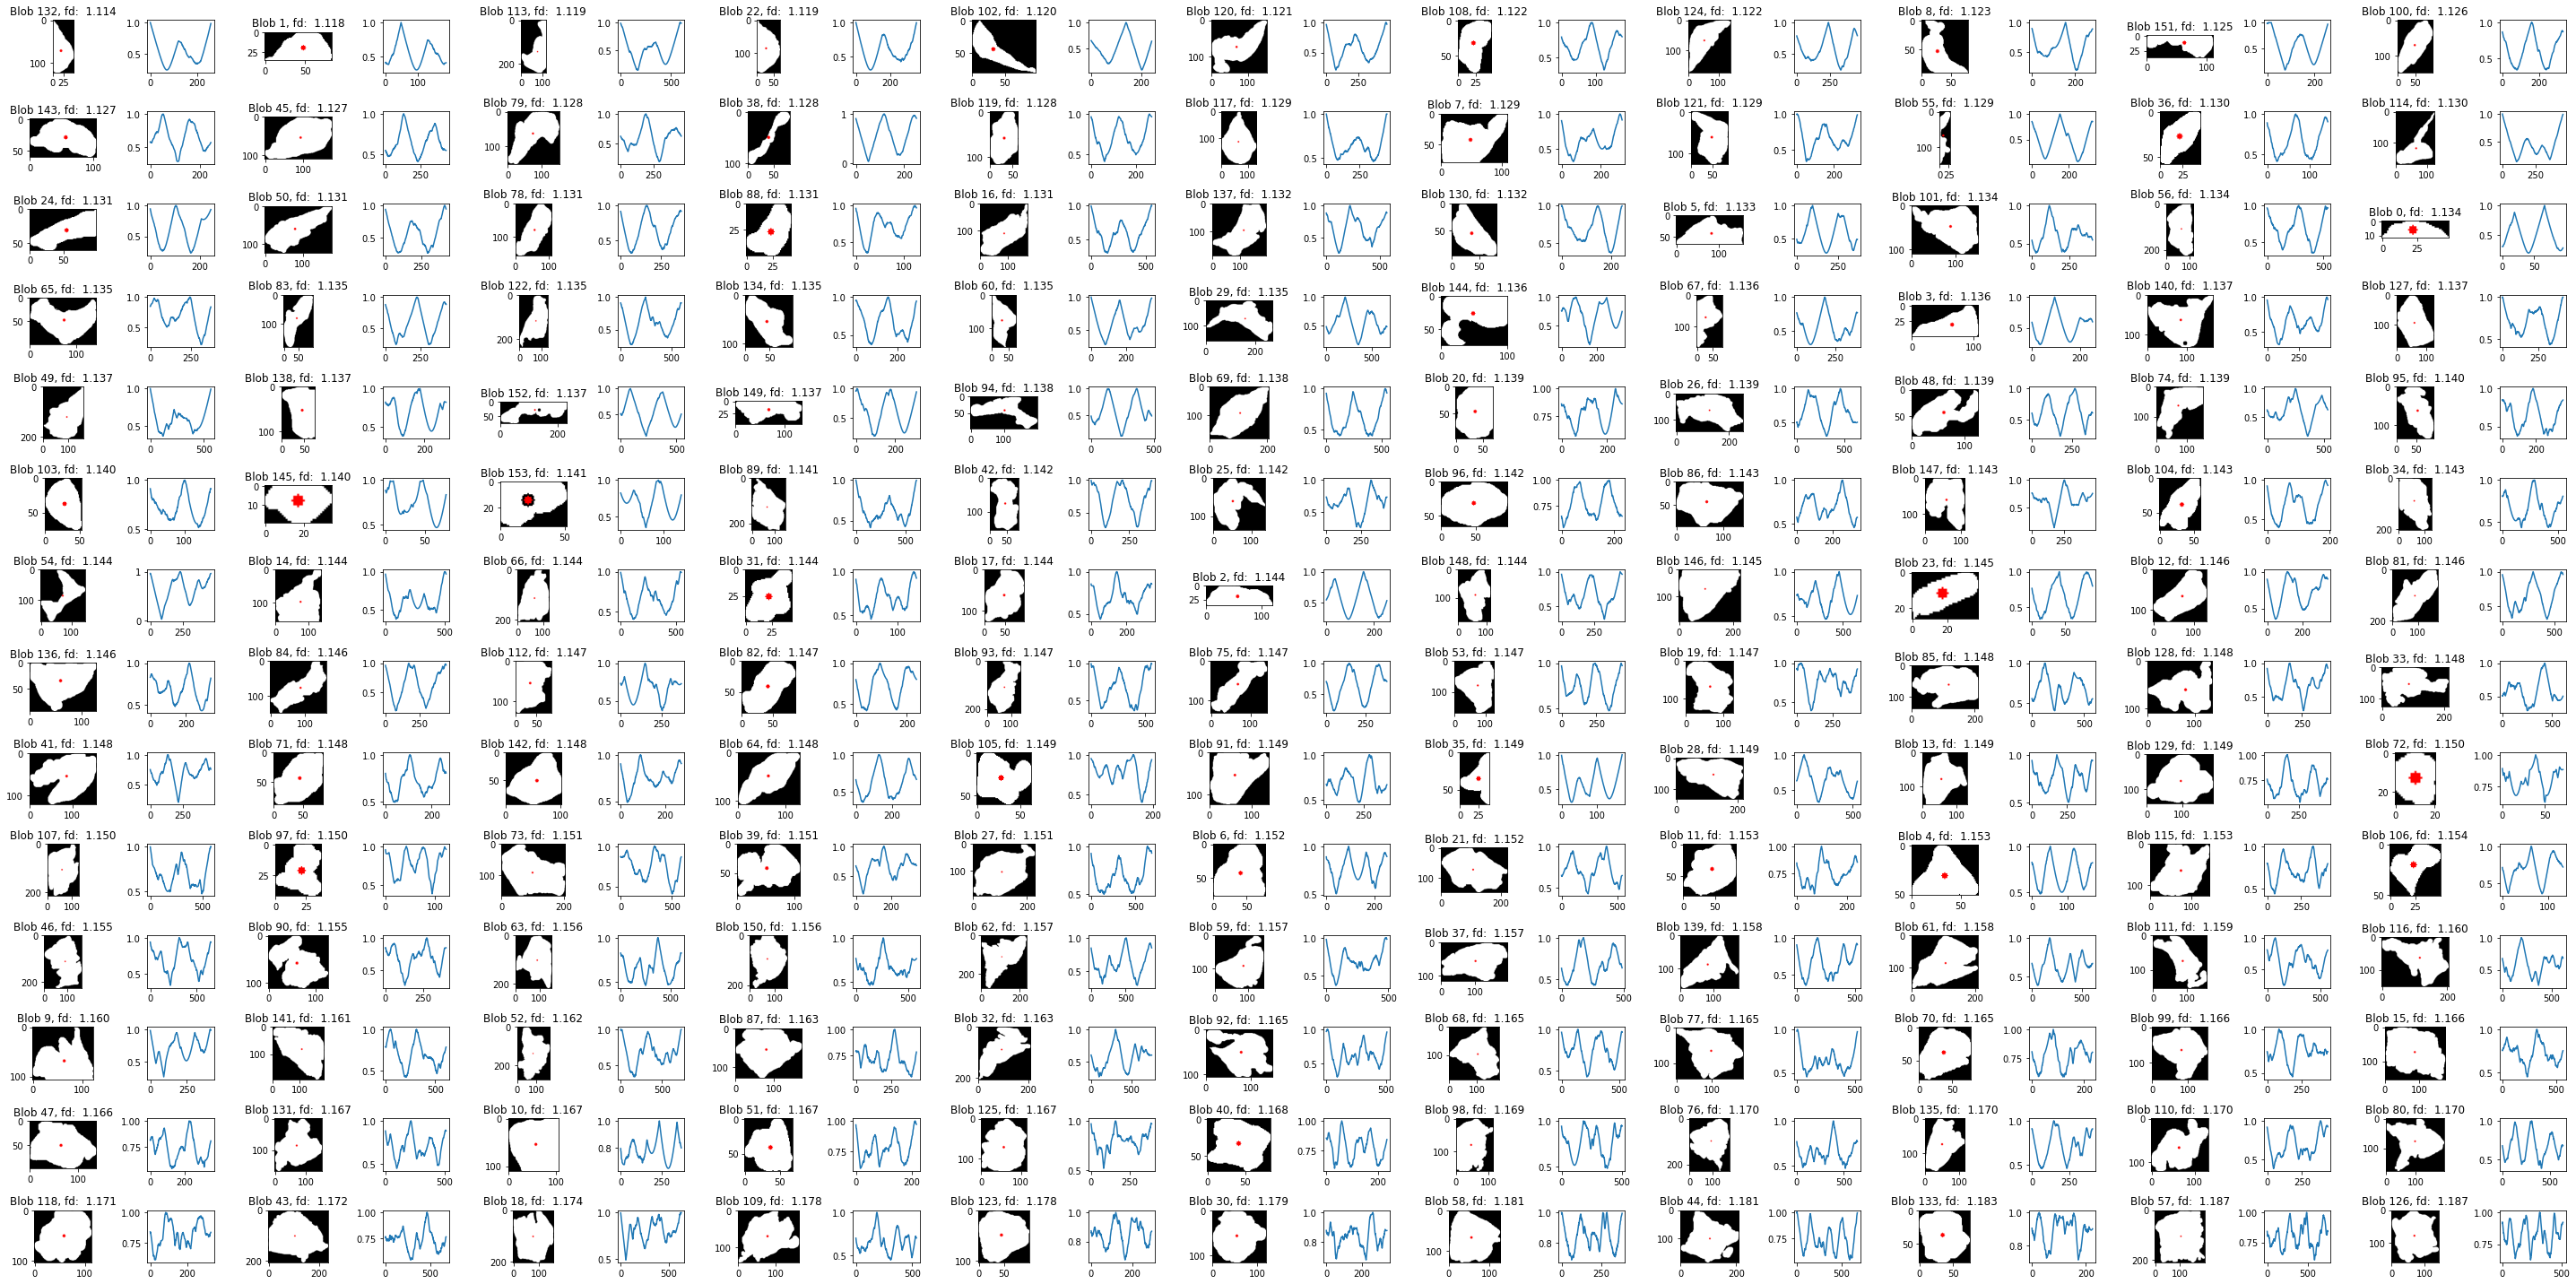

In [312]:
n_rows = 14
n_columns = 11
fig, axes = plt.subplots(n_rows, n_columns*2, figsize=(40, 20))
for index in range(0, n_rows*n_columns*2, 2):
    i = index // (n_columns*2)
    j = index % (n_columns * 2)
    axes[i, j].imshow(cimgs_centroids[sort_index[index//2]])
    axes[i, j + 1].plot(rds[index//2])
    axes[i, j].set_title(f'Blob {sort_index[index//2]}, fd: {fds[index//2]: .3f}')
plt.tight_layout()

In [345]:
hist, bins = np.histogram(rds[0], bins='fd')
hist_norm = hist / hist.sum()

<BarContainer object of 9 artists>

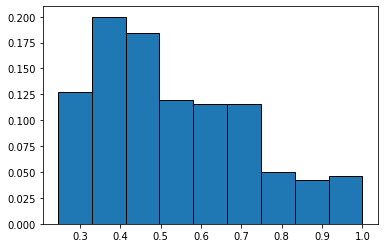

In [354]:
fig, ax = plt.subplots(1)
widths = bins[1:] - bins[:-1]
ax.bar(bins[:-1], hist_norm, width=widths, align='edge', linewidth=1, edgecolor='black')

In [355]:
from scipy.stats import entropy

In [359]:
for rd in rds:
    hist, bins = np.histogram(rd, bins='fd')
    hist_norm = hist / hist.sum()
    print(entropy(hist, base=2))

2.9910654790869784
2.795722424894219
3.517826889446655
3.130692896943914
3.058214065726712
3.312943279090383
2.7176732450532706
3.1246830049041936
3.036748128127611
2.799450689705299
2.7090597825823197
2.9163435402202684
3.048542549267567
3.4734360299198754
2.566908652751824
2.703155962517086
3.360391670657773
3.2886201947431495
3.252829831568163
2.947249764290999
2.227097002488682
3.4319844527489938
2.519383780934155
3.0212759957846735
2.7921187032666914
2.6520472413608682
3.2611571229168828
3.199660787238328
2.8920589515874937
2.9172848151725157
3.2643346599809253
3.1091443220671833
2.233842913398461
3.0186090982148523
2.9477408708122312
3.2397215451303976
2.771511133681932
3.0859731696635664
3.3906412208471655
2.9628538642841167
3.150472670923986
2.8831665789431873
3.650795850648549
3.0428732206206397
3.5533070886672964
2.7292367187847213
3.1385570819195046
2.786421588529492
3.2040557210577503
2.838851824872956
2.676388215516344
3.0965434703109818
2.939767527588433
3.324292893237032

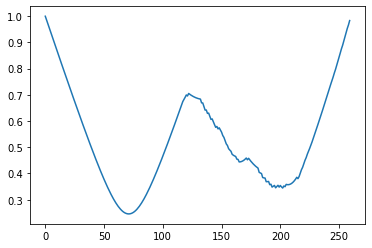

In [360]:
plt.plot(rds[0])

In [383]:
def count_boxes_1d(xs, ys, k, k_max):
    range_y_max = ys.max() - ys.min()
    indexes_x = np.arange(0, len(xs), 2**k)
    ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()
    S = []
    # Optimization: we check for all the ys if they are in some y-range
    # at the same time, and then we collapse the result into boxes
    # (yeah, I feel proud about this trick)
    for j in range(len(ranges_y) - 1):
        r = (ys >= ranges_y[j]) & (ys <= ranges_y[j+1])
        S.append(np.add.reduceat(r, indexes_x))
    boxes = np.vstack(S)
    # print(boxes) # With this you can see the formation of the plot!
    return len(np.where(boxes > 0)[0])


In [433]:
def count_boxes_1d_2(xs, ys, k, k_max):
    range_y_max = ys.max() - ys.min()
    indexes_x = np.arange(0, len(xs), 2**k)
    ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()

    r = (ys >= ranges_y[:-1, np.newaxis]) & (ys <= ranges_y[1:, np.newaxis])
    boxes = np.add.reduceat(r, indexes_x, axis=1)
    # print(boxes) # With this you can see the formation of the plot!
    return len(np.where(boxes > 0)[0])


In [434]:
ys = rds[100]
xs = np.arange(len(ys))
n_points = 4096

f_interp = interp1d(xs, ys)
xs_new = np.linspace(0, len(xs) - 1, n_points, endpoint=True)
ys_new = f_interp(xs_new)
k_max = int(np.floor(np.log2(n_points)))


In [435]:
k = 10
xs = xs_new
ys = ys_new
range_y_max = ys.max() - ys.min()
indexes_x = np.arange(0, len(xs), 2**k)
ranges_y = np.linspace(0, range_y_max, 2**(k_max - k) + 1) + ys.min()
indexes_x, ranges_y

(array([   0, 1024, 2048, 3072]),
 array([0.38956135, 0.54213684, 0.69471233, 0.84728782, 0.99986331]))

In [436]:
ks = np.arange(k_max, 1, -1)
sizes = 2**ks

counts = []
for k in ks:
    c1 = count_boxes_1d(xs_new, ys_new, k, k_max)
    c2 = count_boxes_1d_2(xs_new, ys_new, k, k_max)
    print(k, c1, c2)

12 1 1
11 4 4
10 15 15
9 39 39
8 81 81
7 180 180
6 368 368
5 744 744
4 1466 1466
3 2588 2588
2 3401 3401


In [437]:
%%timeit
for k in ks:
    c1 = count_boxes_1d(xs_new, ys_new, k, k_max)

73.5 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [438]:
%%timeit
for k in ks:
    c2 = count_boxes_1d_2(xs_new, ys_new, k, k_max)

98.7 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [406]:
y_tiles = np.tile(ys, (4, 1))

In [414]:
r = (y_tiles >= ranges_y[:-1, np.newaxis]) & (y_tiles <= ranges_y[1:, np.newaxis])

In [415]:
r.shape

(4, 4096)

In [417]:
np.add.reduceat(r, indexes_x, axis=1)

array([[316, 514, 266, 404],
       [248, 248, 598, 234],
       [233, 262, 160, 210],
       [227,   0,   0, 176]])

In [430]:
r = (ys >= ranges_y[:-1, np.newaxis]) & (ys <= ranges_y[1:, np.newaxis])

In [431]:
r

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [432]:
np.add.reduceat(r, indexes_x, axis=1)

array([[ 59,   0,  16, 224],
       [528, 220, 158, 163],
       [127, 430, 332, 116],
       [310, 374, 518, 521]])